# Welcome to Machine Learning Financial Laboratory


## Introduction

<b>MlFinLab</b> is a powerful tool that incorporates years of research and development into a simple, accessible library for your convenience. We have successfully built a python library that numerous industry experts have utilized to address a wide range of use cases. Some of the use cases include:

- Building financial quantitative strategies from scratch
- Enhancing existing implemented strategies through improved statistical analysis
- Augmenting research with comprehensive financial data analysis

We have designed this jupyter notebook as a simple guide on how to get started with MlFinLab. Together with our Hudson & Thames documentation, we bring you three core advantages to help you learn new techniques: thoroughness, flexibility, and credibility.

Topics covered in this notebook include:

- Installation: A brief overview of how you can import MlFinLab

- Data Preparation: How you can import tick data and extract dollar bars

- Labelling: Assigning target labels to data

- Sampling: How we can deal with overlapping labelled data

- Feature Engineering: How we can create features that can be inputs for a machine learning algorithm

- Feature Importance: A glimpse of a simple model and show which features in that model are mostly influencing the output variable.

- Clustering: A glimpse of our incredible ONC algorithm that takes away the guessing game in k-means clustering.

# 1. Installation

Details for showing the installation process can be found here: https://www.mlfinlab.com/en/latest/getting_started/installation.html


In [359]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import (
    GridSearchCV, 
    KFold, 
    train_test_split, 
    cross_val_score
    )
from sklearn.metrics import (
    roc_curve,
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.utils import resample, shuffle 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf


# 2. Data Preparation

The common data type to use for most financial analysis is tick data. It has many advantages in capturing detailed market dynamics and providing more accurate insights into price movements and trading activity. Among many others, these are some of the advantages of tick data:

- Granularity
- Order flow analysis
- Accurate measurements

In [360]:
# Import tick data
url = "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/tick_data.csv"
data = pd.read_csv(url)
data.head(5)

,Date,Time,Price,Volume
0,2023-03-01,17:00:00.083,804.25,8
1,2023-03-01,17:00:00.083,804.25,1
2,2023-03-01,17:00:00.083,804.25,2
3,2023-03-01,17:00:00.083,804.25,1
4,2023-03-01,17:00:00.083,804.25,1


In [361]:
# Data cleaning and preparation
# We are combining the 'date' and 'time' column and making it 'date'
date_time = data["Date"] + " " + data["Time"]
new_data = pd.concat([date_time, data["Price"], data["Volume"]], axis=1)
new_data.columns = ["date", "price", "volume"]

We need to change our data format to ensure that our tools will read the data accordingly. Our documentation, for each function, will tell you the format the data should be in order to use the function. In this case, our data should be in `[date_time, price, volume]` format.

In [362]:
new_data.head(5)

,date,price,volume
0,2023-03-01 17:00:00.083,804.25,8
1,2023-03-01 17:00:00.083,804.25,1
2,2023-03-01 17:00:00.083,804.25,2
3,2023-03-01 17:00:00.083,804.25,1
4,2023-03-01 17:00:00.083,804.25,1


When analysing financial data, unstructured data sets (in this case tick data), are commonly transformed into a structured format referred to as bars, where a bar usually represents an observation of open, high, low and close prices as well as the volume traded, for a certain interval. <b>MlFinLab</b> implements tick, volume, and dollar bars using traditional standard bar methods as well as the less common information driven bars.

Time, tick, volume and dollar bars are the four main types of standard bar methods. 

For illustrative purposes, the focus will be  on dollar bars, being that they are the most stable of the four. They are the most stable because for instance they do not account for time, rather for movements in prices and they can help filter out noise and focus on significant price movements, potentially providing a clearer view of market trends.

In [363]:
from mlfinlab.data_structures import standard_data_structures
from mlfinlab.sampling import concurrent, bootstrapping

In [364]:
# Dollar Bars
dollar_bars = standard_data_structures.get_dollar_bars(
    new_data, threshold=10000000, batch_size=10000, verbose=False
)
dollar_bars.head(5)

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2023-03-01 17:21:07.831,2883,804.25,806.0,803.00,804.50,12434,6996,2883,10000623.50
1,2023-03-01 19:10:41.010,6121,804.25,806.0,803.75,805.00,12423,6708,3238,10000529.50
2,2023-03-01 20:27:55.076,9590,805.00,807.5,804.75,806.25,12407,6778,3469,10001980.00
3,2023-03-02 00:05:02.333,13827,806.25,808.0,804.25,806.75,12407,5536,4237,10002166.25
4,2023-03-02 02:02:16.730,18561,806.75,808.5,806.00,807.75,12390,7205,4734,10001655.25


Please refer to our documentation for more details on how <b>MlFinLab</b> could be utilised to create other data structures. 

Once you have dollars bars, for instance, there are several analyses and strategies you can employ. Here are a few:
- Statistical Analysis
- Trend Identification
- Volatility Estimation
- Pattern Recognition
- Strategy Development
- Backtesting and Performance Evaluation
-  Risk Management

# 3. Labelling

This is the process of assigning target labels or categories to data points. It involves assigning a specific outcome or classification to each data instance based on certain criteria or rules. It is important when it comes to predictive modeling tasks. The following techniques are available in <b>MlFinLab</b>, accompanied with an example notebook in our documentation :
- Raw Returns
- Fixed Horizon
- Excess of Mean
- Excess of Median
- Bull Bear States
- Return vs Benchmark
- Tail Sets
-Trend Scanning
- Triple-Barrier and Meta-Labeling

Triple-barrier labeling will be demonstrated in this notebook.

A common labeling method used in financial academia is the fixed-time horizon method. While ubiquitous, this method has many drawbacks which can be mitigated by using the triple-barrier method. 

The main concept behind the triple-barrier method is that we have three barriers: an upper barrier, a lower barrier, and a vertical barrier. The upper barrier represents the threshold an observation’s return needs to reach in order to be considered a buying opportunity (and assigned a label of 1), the lower barrier represents the threshold an observation’s return needs to reach in order to be considered a selling opportunity (a label of -1), and the vertical barrier represents the amount of time an observation has to reach it’s given return in either direction before it is assigned a label of 0 (indicating no trade should take place).


In [365]:
# Set date_time column as index
dollar_bars['date_time'] = pd.to_datetime(dollar_bars['date_time'])
dollar_bars = dollar_bars.set_index('date_time')

In [366]:
from mlfinlab.util.volatility import get_daily_vol

<b>MlFinLab</b> is equiped with helper functions, such as get_daily_vol, which  are auxiliary functions or utilities that assist in various tasks related to model development, data preprocessing, analysis, and evaluation. They were created to simplify complex operations, improve code reusability, and enhance the overall efficiency of the modeling process. We wil show some of them in this notebook, but more can be seen in the documentation.

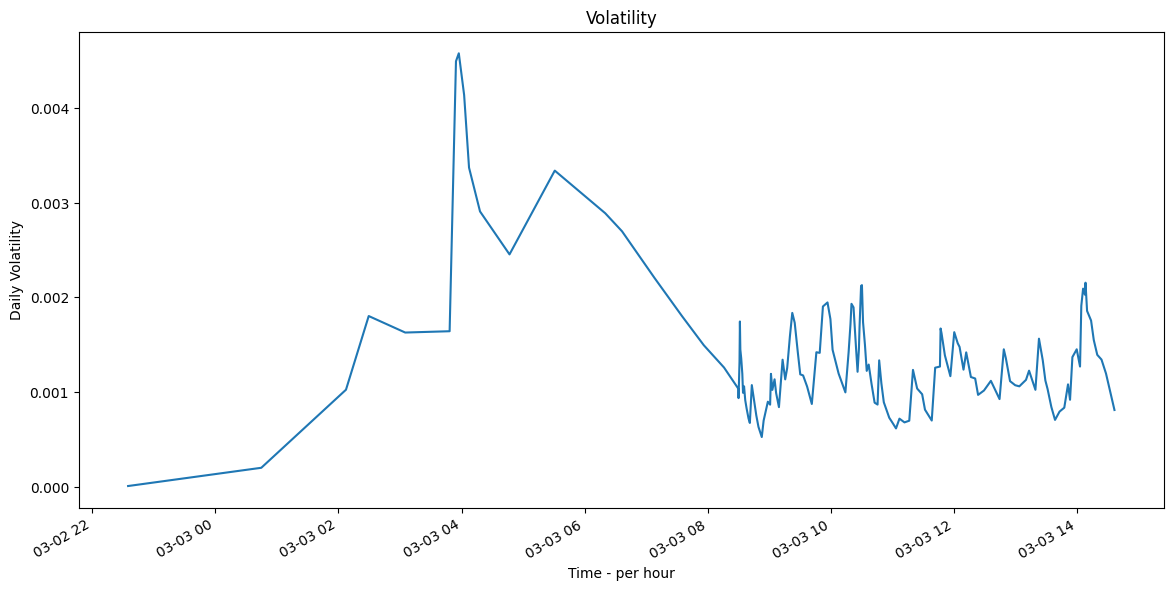

In [367]:
# Compute daily volatility
vol = get_daily_vol(close=dollar_bars['close'], lookback=5)

vol.plot(figsize=(14, 7), title='Volatility')
plt.xlabel('Time - per hour')
plt.ylabel('Daily Volatility')
plt.show()

The large spike occured because of liquidity changes. Liquity can be lower during certain periods, such as overnight or during non-traditional trading hours. Reduced liquidity can result in wider bid-ask spreads and increased price volatility when a large order or significant news event occurs during these times.

###  Filtering

Filters are a valuable feature in financial machine learning that enable you to selectively pinpoint and examine particular events. They function by using a specific conditional trigger, allowing you to concentrate on the most important market data and disregard irrelevant noise that would otherwise skew the analysis.

Our documentation covers a lot more filters that can be used, for this notebook we will focus on CUSUM Filter.

The CUSUM filter is a mathematical technique used in signal processing and statistical analysis. it is primarily used for detecting changes or shifts in the mean value of a data stream or time series. The CUSUM filter continuously calculates the cumulative sum of the deviations between the observed data points and a reference or target value. By monitoring the cumulative sum, it becomes possible to detect when the data deviates significantly from the expected pattern.

The CUSUM filter is often employed in quality control and monitoring systems to identify process changes or anomalies. It is useful for detecting subtle, gradual shifts as well as abrupt changes in data. The filter can be adjusted to have different sensitivities, allowing for customization based on the desired detection capabilities.

Once we have obtained this subset of event-driven bars, we will let the ML algorithm determine whether the occurrence of such events constitutes actionable intelligence. Below is an implementation of the Symmetric CUSUM filter.

More details can be found here : https://www.mlfinlab.com/en/latest/feature_engineering/filters.html

In [368]:
from mlfinlab.filters.filters import cusum_filter

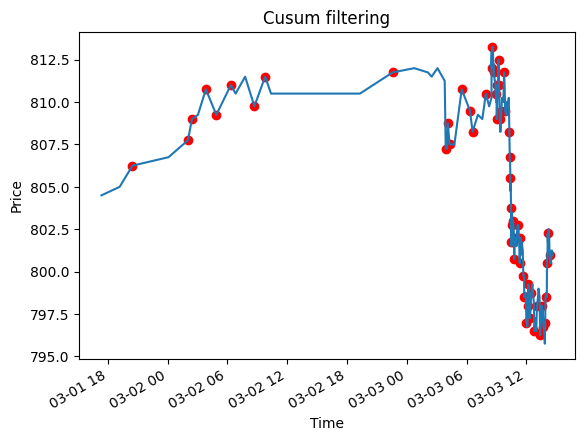

In [369]:
# Apply Symmetric CUSUM filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = cusum_filter(dollar_bars['close'], threshold=vol.mean())        

dollar_series_close = dollar_bars['close']

# plot the close values
df = dollar_series_close
ax = df.plot(title='Cusum filtering')
ax.scatter(cusum_events, df.loc[cusum_events], color = 'red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Here, we have a graph showing the datetimes when events occurred. This is then used later to sample.

In [370]:
from mlfinlab.labeling import labeling

Once we have the events, we can then eomploy triple barrier labeling and get timestampes of vertical barriers

In [371]:
# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(cusum_events, dollar_bars['close'],num_days=1)
vertical_barriers.head()

2023-03-01 20:27:55.076   2023-03-02 22:34:50.407
2023-03-02 02:02:16.730   2023-03-03 02:07:19.974
2023-03-02 02:26:08.166   2023-03-03 02:29:30.148
2023-03-02 03:50:10.860   2023-03-03 03:54:36.152
2023-03-02 04:53:03.996   2023-03-03 05:30:56.657
Name: date_time, dtype: datetime64[ns]

In [372]:
# On those sampled features, we will now apply the triple-barrier method

triple_barrier_events = labeling.get_events(close=dollar_bars['close'],
                                               t_events=cusum_events,
                                               pt_sl=[1, 1],
                                               target=vol,
                                               num_threads=1,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=None)

**NB**

- t_events - These are the timestamps selected by our CUSUM Filter
- pt_sl - This is the profit taking level and stop-loss for a trading strategy. Element 0: Profit taking level (indicates the price level at which you would like to take a profit if the trade moves in your favor). Element 1: stop loss level (indicates the price level at which you want to exit the trade to limit your losses if the trade moves against you). If you set either Element 0 or Element 1 to 0, it disables the respective horizontal barrier. In other words, a value of 0 means that you do not want to set a profit-taking or stop-loss level, and the corresponding barrier will not be active.
- target - This determines the width of the barrier. We used daily volatility in this case.
- These are the timestamps of the vertical barriers.


In [373]:
triple_barrier_events.head()

,t1,trgt,pt,sl
2023-03-02 22:34:50.407,2023-03-03 00:44:44.383,0.000007,1,1
2023-03-03 03:54:36.152,2023-03-03 08:31:07.256,0.004491,1,1
2023-03-03 04:07:20.228,2023-03-03 08:31:07.256,0.003368,1,1
2023-03-03 04:18:02.970,2023-03-03 05:30:56.657,0.002906,1,1
2023-03-03 05:30:56.657,2023-03-03 10:19:19.848,0.003337,1,1


**NB**

- t1 - Time when the first barriers were reached
- trgt - The event's target
- pt - Profit taking multiple
- sl - Stop loss multiple

After getting the barrier events, you can then use our `get_bins` function to get the labels of the top horizontal barrier, bottom horizontal barrier and vertical barrier i.e., {1,-1, 0}. These are the meta-labels, and can also be used where you give the 'side' of the trade.

In [374]:
labels = labeling.get_bins(triple_barrier_events, dollar_bars['close'])
labels.head()

,ret,trgt,bin
2023-03-02 22:34:50.407,0.000308,0.000007,1
2023-03-03 03:54:36.152,0.005884,0.004491,1
2023-03-03 04:07:20.228,0.004019,0.003368,1
2023-03-03 04:18:02.970,0.004025,0.002906,1
2023-03-03 05:30:56.657,-0.004009,0.003337,-1


In [375]:
labels['bin'].value_counts()

bin
 1    25
-1    24
Name: count, dtype: int64

We have 25 long positions and 24 short positions.

The dataset in this case was relatively small, we will now demonstrate with a larger dataset.

**NB**

Our multiprocess functions are there to utilize multiple processes to perform computations or operations on a pandas dataframe or series object in parellel. By leveraging multprocessing, this allows for concurrent execution of the function across multiple CPU cores which potentially speeds up the data processing tasks at hand.

Please refer to the documentation for more detail.

In [376]:
from mlfinlab.util import multiprocess

In [377]:
# Read in data
url = 'https://raw.githubusercontent.com/hudson-and-thames/example-data/main/dollar_bars.csv'
data = pd.read_csv(url)

data.index = pd.to_datetime(data['date_time'])
close_prices = data['close']
len(close_prices)

24079

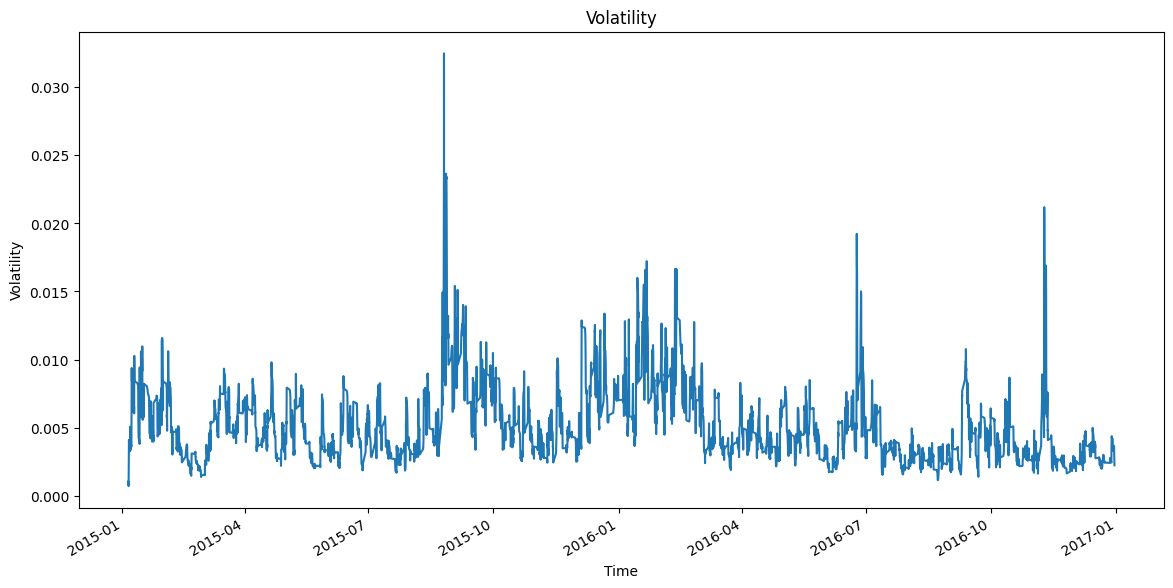

In [378]:
# Compute daily volatility
vol = get_daily_vol(close=close_prices, lookback=50)

vol.plot(figsize=(14, 7), title='Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.show()

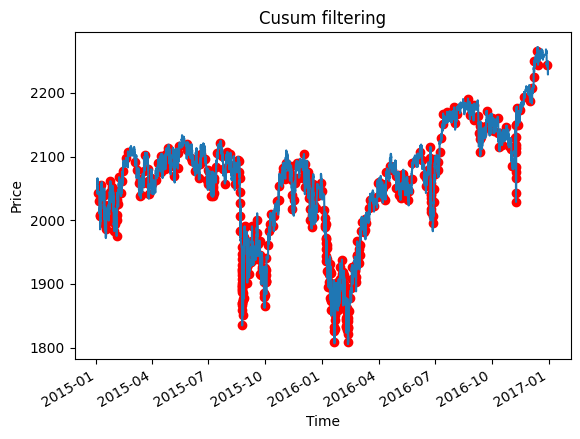

In [379]:
cusum_events = cusum_filter(close_prices, threshold=vol.mean()*2)
# plot the close values
df = close_prices
ax = df.plot(title='Cusum filtering')
plt.xlabel('Time')
plt.ylabel('Price')
ax.scatter(cusum_events, df.loc[cusum_events], color = 'red')
plt.show()

A lot more events noted.

In [380]:
# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(cusum_events, close_prices, num_days=1)
vertical_barriers.head()

2015-01-02 16:13:30.202   2015-01-04 23:20:12.567
2015-01-05 14:54:26.286   2015-01-06 15:01:01.702
2015-01-06 16:01:22.225   2015-01-07 16:08:12.102
2015-01-07 10:55:23.194   2015-01-08 11:20:19.427
2015-01-08 01:48:57.964   2015-01-09 07:30:41.047
Name: date_time, dtype: datetime64[ns]

In [381]:
triple_barrier_events = labeling.get_events(close=close_prices,
                                            t_events=cusum_events,
                                            pt_sl=[1, 1],
                                            target=vol,
                                            min_ret=0.01,
                                            num_threads=1,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=None)

triple_barrier_events.head()

,t1,trgt,pt,sl
2015-01-15 13:45:55.324,2015-01-15 14:57:17.741,0.010148,1,1
2015-01-30 15:34:17.075,2015-02-01 23:26:29.558,0.010072,1,1
2015-08-24 13:30:15.407,2015-08-24 13:32:08.441,0.010124,1,1
2015-08-24 13:32:08.441,2015-08-24 13:37:56.160,0.012639,1,1
2015-08-24 13:37:56.160,2015-08-24 13:42:49.318,0.014763,1,1


In [382]:
labels = labeling.get_bins(triple_barrier_events, close_prices)
labels.head()

,ret,trgt,bin
2015-01-15 13:45:55.324,-0.011029,0.010148,-1
2015-01-30 15:34:17.075,-0.003255,0.010072,0
2015-08-24 13:30:15.407,-0.017010,0.010124,-1
2015-08-24 13:32:08.441,0.012808,0.012639,1
2015-08-24 13:37:56.160,0.015337,0.014763,1


In [383]:
labels['bin'].value_counts()# This gives us a count of the 3 labels 

bin
 1    43
-1    28
 0    24
Name: count, dtype: int64

# 4. Sampling

In 'quant-finance' modeling, sampling refers to the process of discretizing a continuous-time model into discrete-time intervals. It involves selecting specific time points at which to observe or record the values of variables in the model.

As you will remember, we mostly label our data sets using the triple-barrier method. Each label in a triple-barrier event has a label index and a label end time (t1) which corresponds to time when one of barriers were touched.

Now imagine you have 3 samples: A, B and C.

Imagine that

- A was generated at $t_1$ and triggered on $t_8$
- B was generated at $t_3$ and triggered on $t_6$
- C was generated at $t_7$ and triggered on $t_9$

In this case we see that A used information about returns on $[t_1, t_8]$
 to generate label-endtime which overlaps with $[t_3,t_6]$
 which was used by B, however C didn’t use any returns information which was used by to label other samples. Here we would like to introduce the concept of **concurrency**.

 #### Concurrency in labels

We say that labels $y_i$ and $y_j$ are concurrent at $t$ if they are a function of at least one common return at $r_{t-1,t}$. It is desirable to use a data set that has least amount of overlap to train an algorithm.  

 In terms of concurrency label C is the most ‘pure’ as it doesn’t use any piece of information from other labels, while A is the ‘dirtiest’ as it uses information from both B and C. 



We will now apply a function to compute the number of overlapping outcomes at each point in time

In [384]:
# Appy a helper function 
# to compute the number of overlapping outcomes at each point in time
from mlfinlab.util import multiprocess

num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent.num_concurrent_events,
                                             ('molecule', triple_barrier_events.index), num_threads, 
                                            close_series_index=close_prices.index,
                                             label_endtime=triple_barrier_events['t1'])

# Eliminate the duplicates
num_conc_events = num_conc_events.loc[~num_conc_events.index.duplicated(keep='last')]

# Reindex based on the close prices
num_conc_events = num_conc_events.reindex(close_prices.index).fillna(0)
len(num_conc_events)

24079

Then we plot the time-series of the number of concurrent labels on the primary axis, and the time series of exponentially weighted moving standard deviation of returns on the secondary axis 

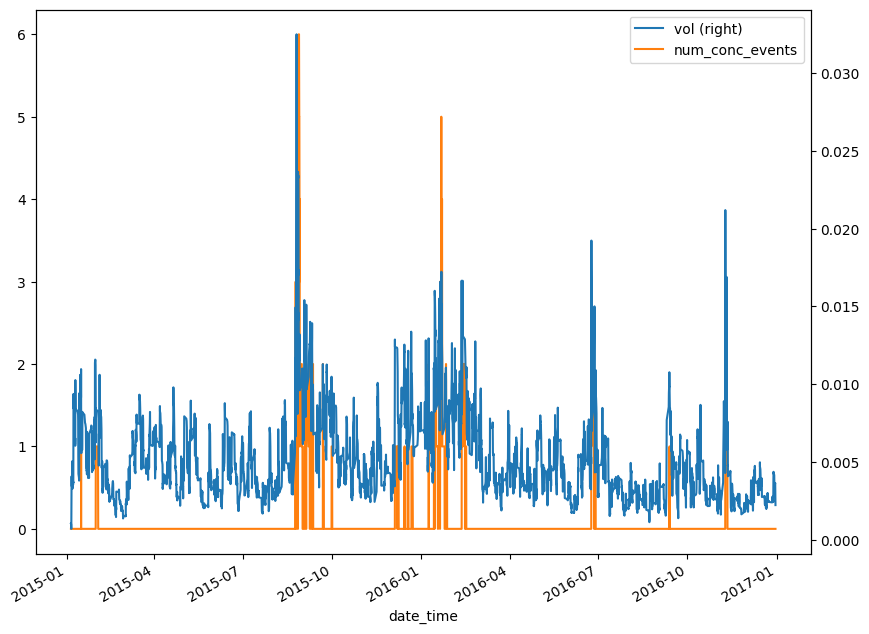

In [385]:
display_df = (pd.DataFrame().assign(vol=vol,
                                    num_conc_events=num_conc_events)
                            .drop_duplicates()
                            .dropna())

# display_df.plot()
display_df[['vol', 'num_conc_events']].plot(secondary_y='vol', figsize=(10,8))
plt.show()

Using the helper function, we will compute the average uniqueness of each label.

Then plot autocorrelation function charts showing the auocorrelation of average uniqueness of labels and the number of concurrent events.

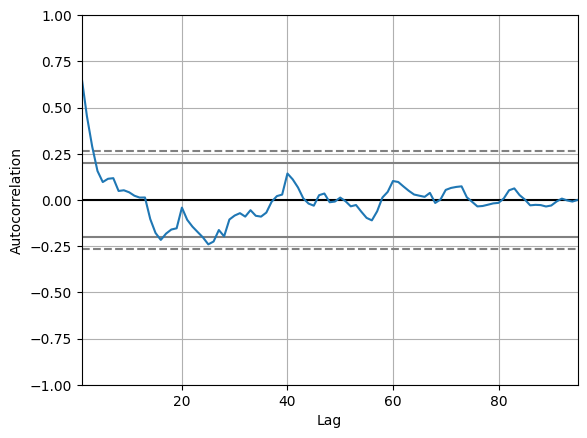

In [386]:
out = multiprocess.mp_pandas_obj(concurrent._get_average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, 
                                 label_endtime=triple_barrier_events['t1'], num_conc_events=num_conc_events)

# ACF plot
pd.plotting.autocorrelation_plot(out);

/home/masimba/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



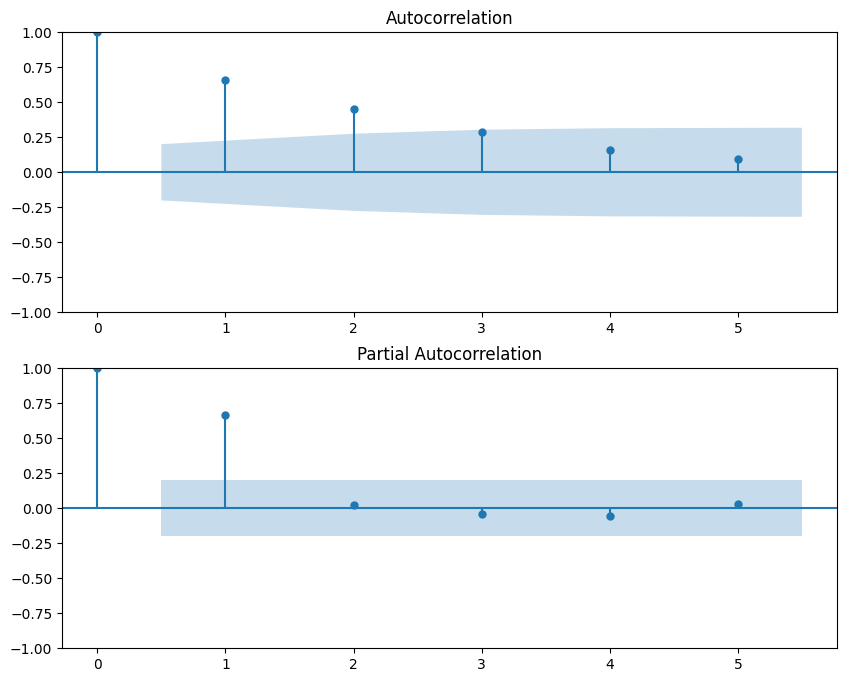

In [387]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
plot_acf(out, ax=plt.gca(), lags=5)
plt.subplot(212)
plot_pacf(out, ax=plt.gca(), lags=5)
plt.show()

The ACF chart shows the auocorrelation of average uniqueness of labels. The fact that the series is statistically significant at lags 1 and 2 indicate that uniqueness persists over time. When the number of concurrent events is zero, then uniqueness is high. This means that we can expect autocorrelation at some level. Here it is at lags 1 and 2.

We can see the value of then removing these overlaps in our model. By understanding average label uniqueness you can measure how ‘pure’ your dataset is based on concurrency of labels. We can measure average label uniqueness using `get_av_uniqueness_from_triple_barrier` function from <b>MlFinLab</b>.

This function is the orchestrator to derive average sample uniqueness from a dateset labeled by the triple barrier method.

In [388]:
from mlfinlab.sampling.concurrent import get_av_uniqueness_from_triple_barrier

In [389]:
av_unique = get_av_uniqueness_from_triple_barrier(
    triple_barrier_events, close_prices, num_threads=3
)
print(av_unique)

2023-07-07 14:17:50.141623 100.0% num_concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.


                               tW
2015-01-15 13:45:55.324  1.000000
2015-01-30 15:34:17.075  1.000000
2015-08-24 13:30:15.407  0.750000
2015-08-24 13:32:08.441  0.666667
2015-08-24 13:37:56.160  0.666667
...                           ...
2016-11-09 13:00:43.075  0.333333
2016-11-09 14:31:49.005  0.417989
2016-11-09 16:31:16.939  0.725490
2016-11-10 08:20:36.695  0.786458
2016-11-10 15:37:05.621  0.500000

[95 rows x 1 columns]


2023-07-07 14:17:50.199107 100.0% _get_average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.



By understanding average label uniqueness you can measure how 'pure' your dataset is based on concurrency of labels.

In [390]:
av_unique.mean()

tW    0.66771
dtype: float64

We would like to build our model, for example, in such a way that it takes into account labels concurrency. In order to do that we need to look at bootstrapping algorithm of Random Forest.

#### Sequential Boostrap


Sequential bootstrapping, also known as time series bootstrapping, is a resampling technique used in quantitative finance to generate simulated data that captures the dependence structure and dynamics of a time series. The primary goal is to generate new time series that preserve the characteristics of the original time series while introducing randomness. This technique is particularly useful when dealing with financial time series data, which often exhibit serial correlation, volatility clustering, and other time-dependent properties.


Consider a set of labels $\{y\}_{i=0,1,2}$
 where:

label $y_0$ is a function of return $r_{0,2}$ 

label $y_1$ is a function of return $r_{2,3}$ 

label $y_2$ is a function of return $r_{4,5}$ 

The first thing we need to do is to build an indicator matrix. Columns of this matrix correspond to samples and rows correspond to price returns timestamps which were used during samples labelling. In our case indicator matrix is :

In [391]:
ind_mat = pd.DataFrame(index = range(0,6), columns=range(0,3))

In [392]:
ind_mat.loc[:, 0] = [1, 1, 1, 0, 0, 0]
ind_mat.loc[:, 1] = [0, 0, 1, 1, 0, 0]
ind_mat.loc[:, 2] = [0, 0, 0, 0, 1, 1]

In [393]:
from mlfinlab.sampling.bootstrapping import (
    get_ind_mat_average_uniqueness, 
    get_ind_matrix, seq_bootstrap
)

In [394]:
triple_barrier_ind_mat = get_ind_matrix(triple_barrier_events, close_prices)

We can get average label uniqueness on indicator matrix using get_ind_mat_average_uniqueness function from mlfinlab

In [395]:
ind_mat_uniqueness = get_ind_mat_average_uniqueness(triple_barrier_ind_mat)

Let's get the first sample average uniqueness (we need to filter out zeros to get unbiased result).

In [396]:
first_sample = ind_mat_uniqueness
first_sample[first_sample > 0].mean()

0.643546441495778

In [397]:
av_unique.iloc[0]

tW    1.0
Name: 2015-01-15 13:45:55.324000, dtype: float64

As you can see it is quite close to values generated by __get_av_uniqueness_from_triple_barrier__ function call. 


In [398]:
ind_mat = ind_mat.values.astype(float)

In [399]:
samples = seq_bootstrap(ind_mat.astype(float), sample_length=4, verbose=True)

[0.33333333 0.33333333 0.33333333]
[0.35714286 0.21428571 0.42857143]
[0.45454545 0.27272727 0.27272727]
[0.5 0.3 0.2]


These are the boostrapped samples indexes.

In [400]:
samples

[1, 2, 2, 1]

# 5. Feature Engineering

The process of creating and selecting relevant input variables from raw data to improve the performance of a financial model, feature engineering is a vital step in modelling; some would argue its the most important step. 

Feature Engineering involves:
- Data Collection
- Data Preprocessing
- Feature Generation
- Feature Selection
- Feature Transformation
- Feature Extraction

All of which your <b>MlFinLab</b> toolkit covers and more details can be explored in our documentation. For this notebook, we will only demonstrate a few concepts.

#### Fractionally Differentiated Features

One of the challenges of quantitative analysis is that time series of prices have trends or a non-constant mean. This makes the time series non-stationary. Non-stationary time series are difficult to work with when we want to do inferential analysis based on the variance of returns, or probability of loss.

Fractionally differentiated features approach entails differentiating a time series to the point where the series is stationary, but not over differencing such that we lose all predictive power.

Starting from MlFinLab version 1.5.0 the execution is up to 10 times faster compared to the models from version 1.4.0 and earlier. (The speed improvement depends on the size of the input dataset)

In [401]:
# We will shrink our dataset so as to have the notebook run faster
data = data.iloc[:800, :]

Given that we know the amount we want to difference our price series, fractionally differentiated features, and the minimum d value that passes the ADF test can be derived as follows:

In [402]:
from mlfinlab.features.fracdiff import frac_diff_ffd, plot_min_ffd

In [403]:
# Derive the fractionally differentiated features
frac_diff_series = frac_diff_ffd(data, 0.5)
# Plot the graph to find the minimum d
# Make sure the input dataframe has a 'close' column
fig, corr_array = plot_min_ffd(data)
fig

The minimum d inm this case is 0.2.

#### Structural Breaks

Structural breaks, like the transition from one market regime to another, represent the shift in the behaviour of market participants. Basically, the first market participant to notice the changes in the market can adapt to them before others and, consequently, gain an advantage over market participants who have not yet noticed market regime changes.

<b>MlFinLab</b> can classify the structural breaks in two categories:

- CUSUM(Chu-Stinchcombe-White CUSUM) tests: These test whether the cumulative forecasting errors significantly deviate from white noise.

- Explosiveness tests: Beyond deviation from white noise, these test whether the process exhibits exponential growth or collapse, as this is inconsistent with a random walk or stationary process, and it is unsustainable in the long run.

##### CUSUM Tests

In [404]:
# We continue using our dollar bars
data = data.iloc[:300]
data.head()

,date_time,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,,
2015-01-01 23:00:23.723,2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478
2015-01-02 07:07:35.156,2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514
2015-01-02 09:35:57.204,2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152
2015-01-02 12:59:42.176,2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502
2015-01-02 14:19:33.847,2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332


In [405]:
from mlfinlab.structural_breaks.cusum import get_chu_stinchcombe_white_statistics

In [406]:
# Change to log prices data
log_prices = np.log(data.close) 
# Chu-Stinchcombe test (one-sided and two-sided)
one_sided_test = get_chu_stinchcombe_white_statistics(
    log_prices, test_type="one_sided", num_threads=1
)
two_sided_test = get_chu_stinchcombe_white_statistics(
    log_prices, test_type="two_sided", num_threads=1
)

In [407]:
one_sided_test.head()

,stat,critical_value
date_time,,
2015-01-02 09:35:57.204,0.329709,2.300684
2015-01-02 12:59:42.176,0.430595,2.387177
2015-01-02 14:19:33.847,0.711578,2.44669
2015-01-02 14:33:39.311,0.810385,2.491874
2015-01-02 14:42:28.315,0.972053,2.528193


In [408]:
two_sided_test.head()

,stat,critical_value
date_time,,
2015-01-02 09:35:57.204,0.434428,2.144761
2015-01-02 12:59:42.176,0.430595,2.387177
2015-01-02 14:19:33.847,0.711578,2.44669
2015-01-02 14:33:39.311,0.810385,2.491874
2015-01-02 14:42:28.315,0.972053,2.528193


#### Explosive Tests

In [409]:
# Chow-Type Dickey-Fuller Test
from mlfinlab.structural_breaks.chow import get_chow_type_stat

# SADF = Supremum Augmented Dickey-Fuller
from mlfinlab.structural_breaks.sadf import get_sadf


In [410]:
# Chow-type test
chow_stats = get_chow_type_stat(log_prices, min_length=20, num_threads=1)
# SADF test with linear model and a constant, lag of 5 and minimum sample length of 20
linear_sadf = get_sadf(
    log_prices, model="linear", add_const=True, min_length=20, lags=5, num_threads=1
)
# Polynomial trend SMT
sm_poly_1_sadf = get_sadf(
    log_prices,
    model="sm_poly_1",
    add_const=True,
    min_length=20,
    lags=5,
    phi=0.5,
    num_threads=1,
)

In [411]:
chow_stats

2015-01-02 16:30:52.544   -0.175202
2015-01-02 16:43:33.673   -0.107024
2015-01-02 17:00:54.364   -0.144171
2015-01-02 17:11:07.124   -0.228948
2015-01-02 17:30:55.709   -0.171156
                             ...   
2015-01-09 14:48:46.704   -0.717940
2015-01-09 14:53:15.645   -0.788383
2015-01-09 14:57:41.810   -0.525157
2015-01-09 15:02:59.709   -0.710083
2015-01-09 15:09:52.867   -0.845589
Length: 260, dtype: float64

In [412]:
linear_sadf

2015-01-02 18:12:28.096   -1.274585
2015-01-02 18:31:31.004   -1.675116
2015-01-02 18:53:22.055   -1.503906
2015-01-02 19:08:52.976   -0.928483
2015-01-02 19:29:46.490   -0.825200
                             ...   
2015-01-09 16:53:47.270   -0.269933
2015-01-09 17:05:15.975    0.891043
2015-01-09 17:13:19.851    1.527804
2015-01-09 17:26:09.757    0.232733
2015-01-09 17:36:38.767   -0.210682
Length: 274, dtype: float64

In [413]:
sm_poly_1_sadf

2015-01-02 18:12:28.096    1.193729
2015-01-02 18:31:31.004    0.960044
2015-01-02 18:53:22.055    0.906867
2015-01-02 19:08:52.976    1.036053
2015-01-02 19:29:46.490    1.154694
                             ...   
2015-01-09 16:53:47.270    1.741069
2015-01-09 17:05:15.975    1.651518
2015-01-09 17:13:19.851    1.537655
2015-01-09 17:26:09.757    1.495390
2015-01-09 17:36:38.767    1.462964
Length: 274, dtype: float64

#### Volatility Estimators

A volatility estimator is a statistical or mathematical method used to estimate or forecast the volatility of a financial asset or market. Volatility refers to the degree of variation or fluctuation in the price or return of an asset over a specific period of time. It is an essential measure in quantitative finance as it provides insights into the risk and uncertainty associated with an investment.

There several popular volatility estimators commonly used:
- Historical Volatility
- Implied Volatility

The choice of volatility estimator depends on the specific requirements, data availability, and the underlying assumptions about the behavior of volatility. It is common to use a combination of different estimators to capture various aspects of volatility dynamics and to validate the robustness of the results.

<b>MlFinLab</b> has several estimators, we will demonstrate the Parkinson estimator below.

#### Parkinson Estimator

Parkinson estimator is five times more efficient than the close-to-close volatility estimator as it would need fewer time periods to converge to the true volatility as it uses two prices from each period instead of just one as with the close-to-close estimator

In [414]:
from mlfinlab.features.volatility_estimators import parkinson

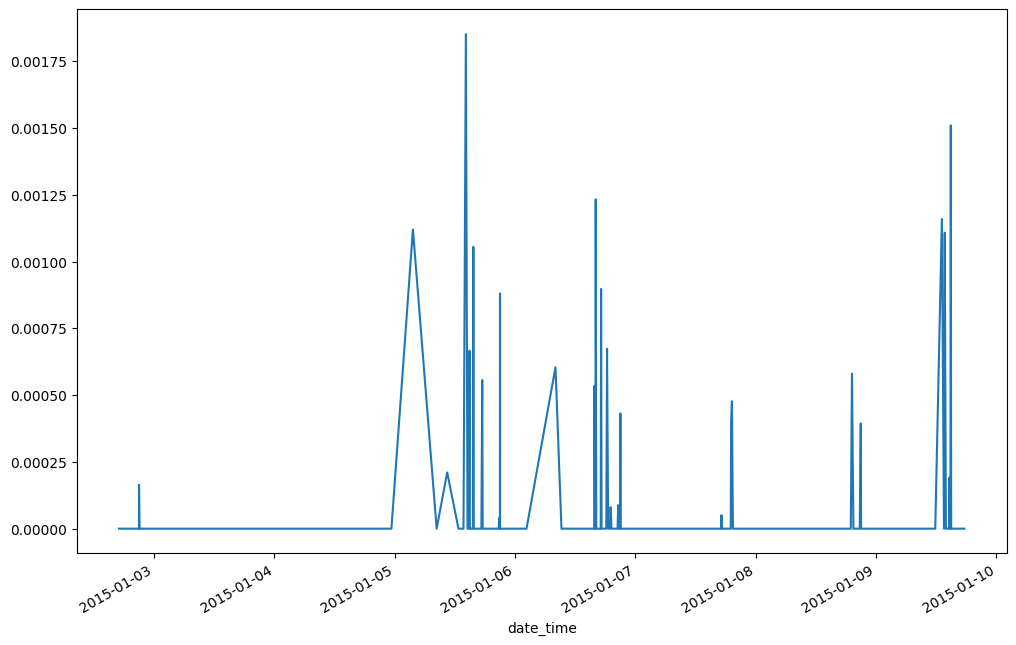

In [415]:
# Calculate volatility with Parkinson estimator and plot volatility
parkinson(data, 22, True).plot(figsize=(12,8));

**NB**

You can toggle from Parkinson volatility estimator using Sinclair, E.(2008) or Lopex de Prado, M. (2008) by changing the `bool` True to False.

# 6. Clustering

Clustering algorithms have several use cases in finance due to their ability to discover patterns, group similar entities, and provide insights into the underlying strucutr of financial data. These insights include:
- Market Segmentation
- Portfolio Construction
- Market Microstructure Analysis

All of which can prove to be useful in your quantitative finance endeavours. <b>MlFinLab</b>  has algorithms, Optimal Number of Clusters (ONC) and Hierarchical Clustering, which are designed to aid you in your clustering work.






#### ONC

The K-means algorithm has two caveats. It requires the user to set the number of clusters in advance and the initialization of clusters is random. Consequently, the effectiveness of the algorithm is random. The ONC algorithm proposed by Marcos Lopez de Prado addresses these two issues.

In [416]:
# Import sample data
asset_returns = pd.read_csv(
    "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/stock_prices.csv",
    index_col="Date",
    parse_dates=True,
)
asset_returns.head(5)

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,49.273335,35.389999,106.639999,52.919998,78.220001,87.629997,37.939999,47.759998,41.299999,79.500000,...,42.090000,51.173328,55.983330,74.529999,67.309998,144.929993,94.379997,77.360001,101.400002,130.630005
2008-01-03,49.716667,35.290001,107.000000,53.119999,78.349998,87.809998,37.919998,48.060001,42.049999,80.440002,...,42.029999,51.293331,55.599998,74.800003,67.500000,144.860001,94.250000,77.459999,101.519997,130.740005
2008-01-04,48.223331,34.599998,106.970001,51.759998,76.570000,88.040001,36.990002,46.919998,40.779999,77.500000,...,42.349998,49.849998,54.536671,72.980003,65.769997,141.309998,94.269997,77.550003,101.650002,128.169998
2008-01-07,48.576668,34.630001,106.949997,51.439999,76.650002,88.199997,37.259998,47.060001,40.220001,77.199997,...,43.230000,50.416672,56.116669,72.949997,65.650002,141.190002,94.680000,77.570000,101.720001,128.059998
2008-01-08,48.200001,34.389999,107.029999,51.320000,76.220001,88.389999,36.970001,46.400002,39.599998,75.849998,...,43.240002,49.566669,55.326672,72.400002,65.360001,138.910004,94.570000,77.650002,101.739998,125.849998


In [417]:
from mlfinlab.clustering import onc

In [418]:
# Calculate correlation matrix of returns
assets_corr = asset_returns.corr()
# Output of the ONC algorithm with 3 simulations for each number of clusters tested
assets_corr_onc, clusters, silh_scores = onc.get_onc_clusters(assets_corr, repeat=5)
clusters

{0: ['TIP', 'IEF', 'LQD', 'XLK', 'XLU', 'SPY', 'TLT', 'BND', 'CSJ', 'DIA'],
 1: ['EEM',
  'EWG',
  'EWJ',
  'EFA',
  'EWQ',
  'EWU',
  'XLB',
  'XLE',
  'XLF',
  'EPP',
  'FXI',
  'VGK',
  'VPL']}

We see the optimal number of clusters in this data set of various asset classes is k = 2.

#### Hierarchical Clustering

Hierarchical clustering is a technique that arranges a set of nested clusters as a tree. It can be agglomerative or divisive. Agglomerative hierarchical clustering merges smaller and similar clusters to form bigger clusters in multiple iterations. A dendrogram is a common technique to visualize the nested clusters. Divisive hierarchical clustering is the opposite concept. At each iteration, bigger clusters are separated into smaller and dissimilar clusters. Hierarchical clustering is useful to discern similar properties in datasets.

In [419]:
from mlfinlab.data_generation.data_verification import (
    plot_optimal_hierarchical_cluster, 
    optimal_hierarchical_cluster,
)
from mlfinlab.data_generation.hcbm import generate_hcmb_mat

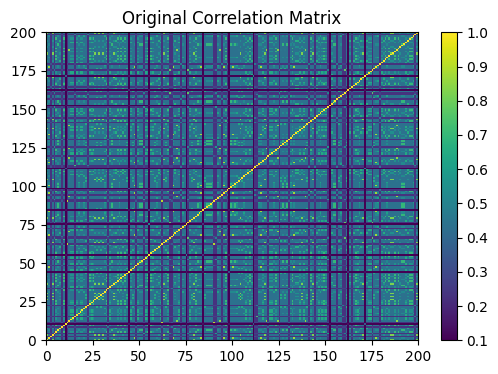

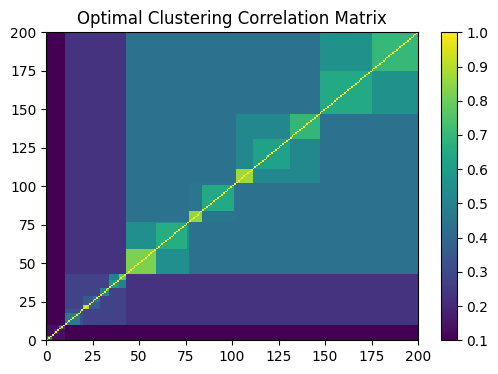

In [420]:
# Initialize parameters
samples = 1
dim = 200
rho_low = 0.1
rho_high = 0.9

# Generate HCBM matrix
hcbm_mat = generate_hcmb_mat(t_samples=samples,
                             n_size=dim,
                             rho_low=rho_low,
                             rho_high=rho_high,
                             permute=True)[0]

# Plot it
plt.figure(figsize=(6, 4))
plt.pcolormesh(hcbm_mat, cmap='viridis')
plt.colorbar()
plt.title("Original Correlation Matrix")

# Obtain optimal clusters from HCBM matrix
ordered_corr = optimal_hierarchical_cluster(hcbm_mat, method="ward")

# Plot it
plt.figure(figsize=(6, 4))
plt.pcolormesh(ordered_corr, cmap='viridis')
plt.colorbar()
plt.title("Optimal Clustering Correlation Matrix")

plt.show()

# 7. Feature Importance

Suppose we have a scenario where as part of the quantitative research team you need to understand or rather determine the relevance or contribution of different features (also known as variables, predictors, or independent variables) in predicting the target variable of our model. 

Feature importance provides us with those insights; insights into which features have the most significant impact on the model's predictions. 

Particularly if we are dealing with some sort of decision tree-based model, such as Random Forest or Gradient Boosting models, feature importance scores give us how much each feature contributes to reducing impurity or error in the model.

<b>MlFinLab</b> provides 3 algorithms for Feature Importance
These are:

- Mean Decrease Impurity (MDI): This score can be obtained from tree-based classifiers and corresponds to sklearn’s feature_importances attribute. MDI uses in-sample (IS) performance to estimate feature importance.

- Mean Decrease Accuracy (MDA): This method can be applied to any classifier, not only tree based. MDA uses out-of-sample (OOS) performance in order to estimate feature importance.

- Single Feature Importance (SFI): MDA and MDI feature suffer from substitution effects. If two features are highly correlated, one of them will be considered as important while the other one will be redundant. SFI is a OOS feature importance estimator which doesn’t suffer from substitution effects because it estimates each feature importance separately.

We will create a simple model involving SPY data from Yahoo Finance. The example also incorporates some of the concepts we have already covered above in the notebook.

In [421]:
from mlfinlab.ensemble.sb_bagging import SequentiallyBootstrappedBaggingClassifier
from mlfinlab.feature_importance.importance import (
    mean_decrease_impurity,
    mean_decrease_accuracy,
    single_feature_importance,
    plot_feature_importance,
)

In [422]:
# Fetch data from Yahoo Finance
data = yf.download("SPY", start="2012-03-25", end="2013-12-09", progress=False)

# Create moving averages
fast_window = 50
slow_window = 100
data["fast_mavg"] = (
    data["Close"]
    .rolling(window=fast_window, min_periods=fast_window, center=False)
    .mean()
)
data["slow_mavg"] = (
    data["Close"]
    .rolling(window=slow_window, min_periods=slow_window, center=False)
    .mean()
)

In [423]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume,fast_mavg,slow_mavg
Date,,,,,,,,
2012-03-26,140.649994,141.610001,140.600006,141.610001,114.699615,120164000,NaN,NaN
2012-03-27,141.740005,141.830002,141.080002,141.169998,114.343277,119868500,NaN,NaN
2012-03-28,141.100006,141.320007,139.639999,140.470001,113.776276,148562100,NaN,NaN
2012-03-29,139.639999,140.490005,139.089996,140.229996,113.581863,164963700,NaN,NaN
2012-03-30,140.919998,141.050003,140.050003,140.809998,114.051651,135486800,NaN,NaN


In [424]:
# Compute sides
data["side"] = np.nan
long_signals = data["fast_mavg"] >= data["slow_mavg"]
short_signals = data["fast_mavg"] < data["slow_mavg"]
data.loc[long_signals, "side"] = 1
data.loc[short_signals, "side"] = -1

In [425]:
from mlfinlab.labeling.labeling import add_vertical_barrier, get_events, get_bins

In [426]:
# Remove Look ahead bias by lagging the signal
data["side"] = data["side"].shift(1)

# Filter events using the CUSUM filter
daily_vol = get_daily_vol(close=data["Close"], lookback=50)
cusum_events = cusum_filter(data["Close"], threshold=daily_vol.mean() * 0.5)
# Do triple-barrier labelling
vertical_barriers = add_vertical_barrier(
    t_events=cusum_events, close=data["Close"], num_days=1
)
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = get_events(
    close=data["Close"],
    t_events=cusum_events,
    pt_sl=pt_sl,
    target=daily_vol,
    min_ret=min_ret,
    num_threads=1,
    vertical_barrier_times=vertical_barriers,
    side_prediction=data["side"],
)
labels = get_bins(triple_barrier_events, data["Close"])

In [427]:
# Feature Engineering
X = pd.DataFrame(index=data.index)
# Volatility
data["log_ret"] = np.log(data["Close"]).diff()
X["volatility_50"] = (
    data["log_ret"].rolling(window=50, min_periods=50, center=False).std()
)
X["volatility_31"] = (
    data["log_ret"].rolling(window=31, min_periods=31, center=False).std()
)
X["volatility_15"] = (
    data["log_ret"].rolling(window=15, min_periods=15, center=False).std()
)

In [428]:
# Autocorrelation
window_autocorr = 50
X["autocorr_1"] = (
    data["log_ret"]
    .rolling(window=window_autocorr, min_periods=window_autocorr, center=False)
    .apply(lambda x: x.autocorr(lag=1), raw=False)
)
X["autocorr_2"] = (
    data["log_ret"]
    .rolling(window=window_autocorr, min_periods=window_autocorr, center=False)
    .apply(lambda x: x.autocorr(lag=2), raw=False)
)
X["autocorr_3"] = (
    data["log_ret"]
    .rolling(window=window_autocorr, min_periods=window_autocorr, center=False)
    .apply(lambda x: x.autocorr(lag=3), raw=False)
)
X["autocorr_4"] = (
    data["log_ret"]
    .rolling(window=window_autocorr, min_periods=window_autocorr, center=False)
    .apply(lambda x: x.autocorr(lag=4), raw=False)
)
X["autocorr_5"] = (
    data["log_ret"]
    .rolling(window=window_autocorr, min_periods=window_autocorr, center=False)
    .apply(lambda x: x.autocorr(lag=5), raw=False)
)

In [429]:
# Log-return momentum
X["log_t1"] = data["log_ret"].shift(1)
X["log_t2"] = data["log_ret"].shift(2)
X["log_t3"] = data["log_ret"].shift(3)
X["log_t4"] = data["log_ret"].shift(4)
X["log_t5"] = data["log_ret"].shift(5)
X.dropna(inplace=True)
labels = labels.loc[
    X.index.min() : X.index.max(),
]
triple_barrier_events = triple_barrier_events.loc[
    X.index.min() : X.index.max(),
]
X = X.loc[labels.index]
X_train = X  # We'll use all examples in this particular case
y_train = labels.loc[X_train.index, "bin"]

#### Cross-Validation
The purpose of performing cross validation is to reduce the probability of over-fitting and the book recommends it as the main tool of research. There are two innovations compared to the classical K-Fold Cross Validation implemented in sklearn.

- The first one is a process called purging which removes from the training set those samples that are build with information that overlaps samples in the testing set.

- The second innovation is a process called embargo which removes a number of observations from the end of the test set. This further prevents leakage where the purging process is not enough. 

In [430]:
from mlfinlab.cross_validation.cross_validation import (
    PurgedKFold, 
    ml_cross_val_score,
)

In [431]:
# Create, fit and cross-validate the model
base_estimator = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=42,
    max_depth=3,
    criterion="entropy",
    min_samples_leaf=4,
    min_samples_split=3,
    max_features="auto",
)
clf = BaggingClassifier(
    n_estimators=452,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    base_estimator=base_estimator,
)
_ = clf.fit(X_train, y_train)
cv_gen = PurgedKFold(
    n_splits=3,
    samples_info_sets=triple_barrier_events.loc[X_train.index].t1,
    pct_embargo=0.10,
)
cv_score_acc = ml_cross_val_score(
    clf,
    X_train,
    y_train,
    cv_gen,
    sample_weight_train=None,
    scoring=accuracy_score,
    require_proba=False,
)
cv_score_f1 = ml_cross_val_score(
    clf,
    X_train,
    y_train,
    cv_gen,
    sample_weight_train=None,
    scoring=f1_score,
    require_proba=False,
)

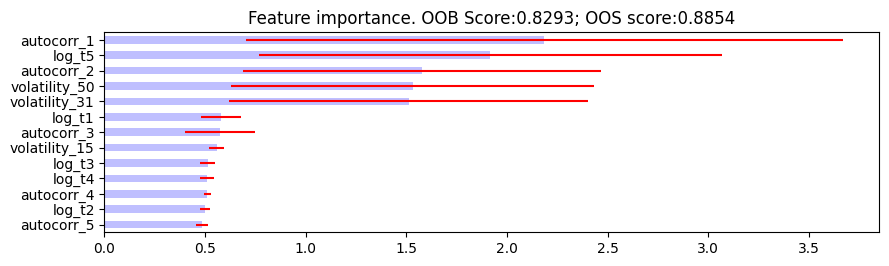

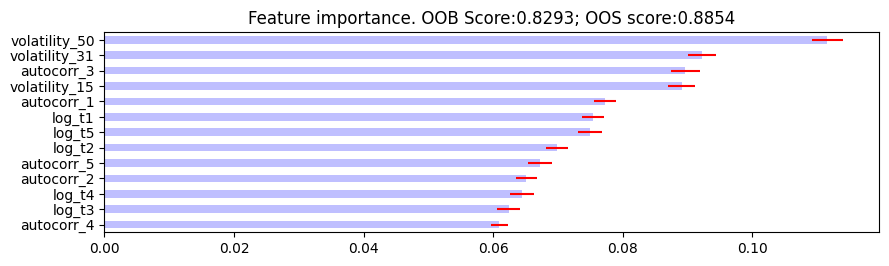

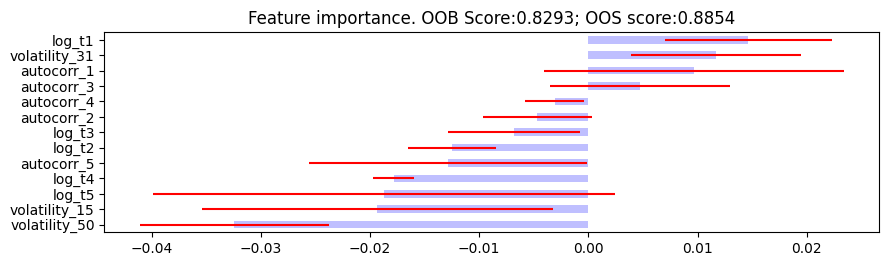

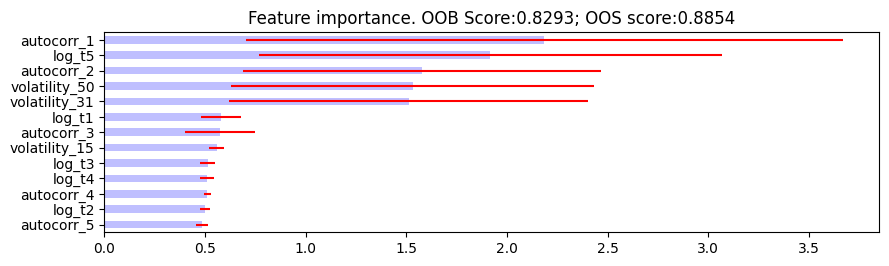

In [432]:
# Produce the MDI, MDA, SFI feature maps
mdi_feature_imp = mean_decrease_impurity(clf, X_train.columns)
mda_feature_imp = mean_decrease_accuracy(
    clf, X_train, y_train, cv_gen, scoring=log_loss
)
sfi_feature_imp = single_feature_importance(
    clf, X_train, y_train, cv_gen, scoring=log_loss
)
# Plot
plot_feature_importance(
    mdi_feature_imp, oob_score=clf.oob_score_, oos_score=cv_score_acc.mean()
) 
plot_feature_importance(
    mda_feature_imp, oob_score=clf.oob_score_, oos_score=cv_score_acc.mean()
) 
plot_feature_importance(
    sfi_feature_imp, oob_score=clf.oob_score_, oos_score=cv_score_acc.mean()
) 

# 8. Backtesting

Backtesting is a critical process in quantitative finance used to evaluate the performance and effectiveness of a trading or investment strategy. It involves applying a strategy to historical market data to simulate how it would have performed in the past. The goal of backtesting is to assess the strategy's potential profitability, risk, and robustness before deploying it in real-time trading or investment.

Backtest stats, or backtest statistics, refer to the performance metrics and statistical measures derived from the backtesting process. These stats provide insights into the strategy's historical performance and risk characteristics. Some commonly used backtest stats include:

- Concentration of bets for positive and negative returns.,
- Drawdown and time underwater,
- Sharpe ratio (annualized, probabistic, deflated),
- etc.

In [433]:
# Read in data
url = "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/dollar_bars.csv"
data = pd.read_csv(url, index_col='date_time')
data.index = pd.to_datetime(data.index)
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2015-01-01 23:00:23.723,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478
2015-01-02 07:07:35.156,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514
2015-01-02 09:35:57.204,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152
2015-01-02 12:59:42.176,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502
2015-01-02 14:19:33.847,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332


In [434]:
# Transforming data to log returns from one long position
logret_series = np.log(data['close']).diff()[1:]

Transforming data to log returns from a long position is a common step performed before calculating backtest statistics in quantitative finance. There are several reasons why log returns are often preferred over raw price or value data:

- Stationarity
- Normality
- Linearization
- Comparison

Before calculating backtest statistics, transforming data to log returns from a long position allows for more meaningful analysis and model development. It aligns with assumptions and requirements of many quantitative finance models and statistical techniques, improves the stationarity of the data, and enables easier comparison and analysis of different assets or strategies.

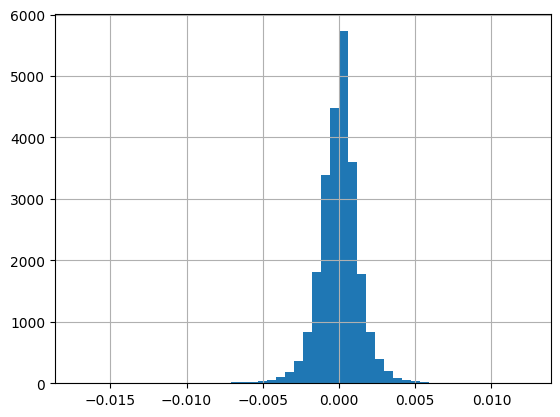

In [435]:
logret_series.hist(bins=50)
plt.show()

In [436]:
from mlfinlab.backtest_statistics.statistics import (all_bets_concentration, 
                                                        drawdown_and_time_under_water, 
                                                        sharpe_ratio, information_ratio,
                                                        probabilistic_sharpe_ratio,
                                                        deflated_sharpe_ratio)

#### Bet Concentration

A  a measure that assesses the concentration or distribution of bets or positions taken by a trading strategy. It quantifies how focused or diversified the strategy's holdings are across different assets or positions.

Bet concentration is particularly relevant for evaluating risk management and diversification within a portfolio or trading strategy. A high degree of bet concentration indicates that a strategy is heavily concentrated in a few positions or assets, which can amplify risks if those specific positions perform poorly. Conversely, a more diversified portfolio with lower bet concentration spreads risk across multiple positions, potentially reducing the impact of individual position performance on overall returns.


In [437]:
# Using MlFinLab package function for detailed concentration output
pos_concentr, neg_concentr, hourly_concentr = all_bets_concentration(logret_series, frequency='H')

In [438]:
print('HHI index on positive log returns is' , pos_concentr)

HHI index on positive log returns is 8.409198932490506e-05


Concentration (or HHI index) on positive log returns is fairly close to zero. From its properties, we can conclude that the log returns distribution is likely to have no fat right tail.

In [439]:
print('HHI index on log returns divided into hourly bins is' , hourly_concentr)

HHI index on log returns divided into hourly bins is 0.00018884181203148828


Concentration (or HHI index) on time between bars (from the observed dataset, roughly 1h between bars) is low. This means bets are not concentrated in time or are close to being uniformly distributed across time.

#### Drawdown and time underwater

**Drawdown** is the peak-to-trough decline in the valye of an investment or portfolio over a specific period. It measures the largest percentage decline from a previous peak value before a new peak is reached. Drawdowns help quantify the magnitude of losses or declines experienced during unfavorable market conditions.

**Time Underwater** measures the duration or length of time that an investment or portfolio remains below a previous peak value. It indicates the period during which you as an investor will experience losses or subpar performance relative to previous highs.

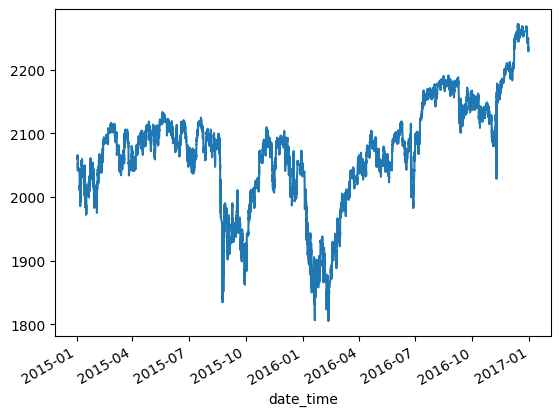

In [440]:
# Getting series of prices to represent the value of one long portfolio
price_series = data['close'][1:]

# Looking at the performance of a protfolio
price_series.plot()
plt.show()

In [441]:
# Getting drawdowns and time under water series
drawdown, tuw = drawdown_and_time_under_water(price_series, dollars = False)
drawdown_dollars, _ = drawdown_and_time_under_water(price_series, dollars = True)

print('The 95th percentile of Drawdown is' , drawdown.quantile(.95))
print('The 95th percentile of Drawdown in dollars is' , drawdown_dollars.quantile(.95))
print('The 95th percentile of Time under water' , tuw.quantile(.95))

The 95th percentile of Drawdown is 0.02625128796377076
The 95th percentile of Drawdown in dollars is 56.19999999999995
The 95th percentile of Time under water 0.048467631684424146


This means that from the observed set, 95% of drawdowns are below 0.026 or 2.7% of the portfolio (If assuming long position). In the dollar equivalent, it is $56.19.

#### Sharpe ratio

The Sharpe ratio is a widely used measure in finance that quantifies the risk-adjusted return of an investment or trading strategy. It was developed by Nobel laureate William F. Sharpe and is used to evaluate the excess return earned per unit of risk taken.

The Sharpe ratio is calculated as the ratio of the excess return (the difference between the asset or strategy's return and a risk-free rate) to the standard deviation of those returns. The formula for the Sharpe ratio is:

Sharpe Ratio = (Asset Return - Risk-Free Rate) / Asset Standard Deviation.

**Probabilistic sharpe ration (PSR)** provides an adjusted estimate of SR, by removing the inflationary effect caused by short series with skewed and/or fat-tailed returns.

**Deflated sharpe ratio (DSR)** is a PSR where the rejection threshold is adjusted to reflect the multiplicity of trials. DSR is estimated as $PSR[SR^∗]$, where the benchmark Sharpe ratio, $SR^*$, is no longer user-defined but calculated from SR estimate trails.

As no benchmark Sharpe ratio is provided, let's assume it to be at 0.6.

In [442]:
# Using simple formula for annual return calculation
days_observed = (price_series.index[-1] - price_series.index[0]) / np.timedelta64(1, 'D')
cumulated_return = price_series[-1]/price_series[0]

# Using 365 days instead of 252 as days observed are calculated as calendar
# days between the first observation and the last
annual_return = (cumulated_return)**(365/days_observed) - 1

In [443]:
# Uning MlFinLab package function to get SR
annualized_sr = sharpe_ratio(logret_series, entries_per_year=252, risk_free_rate=0)
print('Annualized Sharpe Ratio is' , annualized_sr)

Annualized Sharpe Ratio is 0.04044207645744183


In [444]:
probabilistic_sr = probabilistic_sharpe_ratio(observed_sr=annualized_sr, 
                                                                     benchmark_sr=0.6, 
                                                                     number_of_returns=days_observed, 
                                                                     skewness_of_returns=logret_series.skew(), 
                                                                     kurtosis_of_returns=logret_series.kurt())
print('Probabilistic Sharpe Ratio with benchmark SR of 0.6 is' , probabilistic_sr)

Probabilistic Sharpe Ratio with benchmark SR of 0.6 is 3.5357233852188473e-51


As the PSR value is lower than 0.95, we have to reject the hypothesis that the Sharpe ratio is 0.6 for the 5% significance level.

In [445]:
# DSR function also allows the output of benchmark SR calculated when benchmark_out 
# flag is set to True.
benchmark_sr_dsr = deflated_sharpe_ratio(observed_sr=annualized_sr, sr_estimates=[0.5**(1/2), 100], 
                                                                number_of_returns=days_observed, 
                                                                skewness_of_returns=logret_series.skew(), 
                                                                kurtosis_of_returns=logret_series.kurt(),
                                                                estimates_param=True, benchmark_out=True)

print('Benchmark Sharpe ratio used in DSR is' , benchmark_sr_dsr)

Benchmark Sharpe ratio used in DSR is 1.7894064662732079


In this notebook, we explored the basics of getting started with **MlFinLab**, providing an overview of its functionalities and demonstrating how to perform common tasks. We covered key concepts such as data retrieval, data manipulation, statistical analysis, and backtesting of trading strategies.

By leveraging the power of **MlFinLab**, you can streamline your workflow, access robust financial data, and implement and evaluate trading strategies with greater efficiency. The library offers a range of tools and functions that facilitate data analysis, modeling, and performance evaluation (more can be found here in our documentation: https://www.mlfinlab.com/en/latest/index.html)

Remember, this notebook serves as an introduction to the library and its functionalities. As you delve deeper into quantitative finance, it is important to continue exploring and experimenting with the available features, customizing them to your specific needs and datasets. The library's documentation and online resources can provide further guidance and support for more advanced usage.

Happy coding and may your quantitative finance endeavors be successful!

https://www.mlfinlab.com/en/latest/index.html